In [1]:
%cd ..

/home/cole/Documents/dl-final-project


In [31]:
import torch
from model.resnet import Prototype
from data import get_labeled_set, get_unlabeled_set, make_bounding_box_images, tensor_to_image

import matplotlib.pyplot as plt
import numpy as np

In [32]:
model = Prototype('cpu')
# model.device = 'cpu'
# model.is_variational = True

file_path = '/home/cole/labeled-resnet-latest.torch'
model.load_state_dict(torch.load(file_path, 
                                 map_location=torch.device('cpu')))
model = model.eval()

In [33]:
_, unlabeled_trainloader = get_unlabeled_set(batch_size=1)
images, _ = iter(unlabeled_trainloader).next()

In [34]:
img = images[0]
img_recon, _, _ = model(img[None, ...], 'single-image')

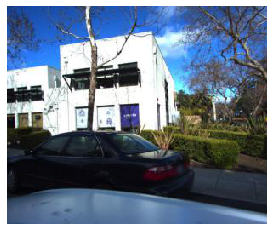

In [35]:
plt.imshow(img.numpy().transpose(1, 2, 0))
plt.axis('off');

In [36]:
# img_recon = torch.sigmoid(img_recon[0])

In [37]:
img_recon.shape

torch.Size([1, 3, 256, 306])

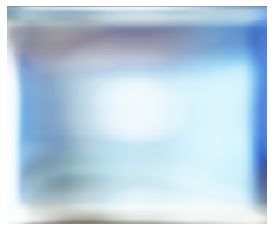

In [38]:
plt.imshow(img_recon[0].detach().numpy().transpose(1, 2, 0))
plt.axis('off');

In [39]:
(_, labeled_trainloader), (_, labeled_testloader) = get_labeled_set(batch_size=3, validation=0.2)

==> Validation Index: 128


In [60]:
images, targets, road_map = iter(labeled_testloader).next()

In [41]:
imgs = images[0]

In [66]:
torch.stack(road_map).float()

tensor([[[0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [42]:
imgs[None, ...].shape

torch.Size([1, 6, 3, 256, 306])

In [43]:
recon_map , _, _= model(imgs[None, ...], mode='object-map')

In [44]:
recon_map.shape

torch.Size([1, 3, 800, 800])

In [45]:
recon_map[0][0]

tensor([[0.9996, 0.9996, 0.9999,  ..., 0.9999, 0.9996, 0.9996],
        [0.9996, 0.9996, 0.9999,  ..., 0.9999, 0.9996, 0.9996],
        [0.9999, 0.9999, 1.0000,  ..., 1.0000, 0.9999, 0.9999],
        ...,
        [0.9979, 0.9979, 0.9992,  ..., 0.9989, 0.9969, 0.9969],
        [0.9956, 0.9956, 0.9980,  ..., 0.9973, 0.9931, 0.9931],
        [0.9956, 0.9956, 0.9980,  ..., 0.9973, 0.9931, 0.9931]],
       grad_fn=<SelectBackward>)

In [46]:
torch.sigmoid(recon_map[0][0])

tensor([[0.7310, 0.7310, 0.7310,  ..., 0.7310, 0.7310, 0.7310],
        [0.7310, 0.7310, 0.7310,  ..., 0.7310, 0.7310, 0.7310],
        [0.7310, 0.7310, 0.7311,  ..., 0.7311, 0.7310, 0.7310],
        ...,
        [0.7306, 0.7306, 0.7309,  ..., 0.7308, 0.7305, 0.7305],
        [0.7302, 0.7302, 0.7307,  ..., 0.7305, 0.7297, 0.7297],
        [0.7302, 0.7302, 0.7307,  ..., 0.7305, 0.7297, 0.7297]],
       grad_fn=<SigmoidBackward>)

In [47]:
channel = 1
mask = torch.softmax(recon_map[0], 0).detach().numpy()[channel] * 255.0
mask

array([[54.067654, 54.067654, 54.053474, ..., 54.054863, 54.081303,
        54.081303],
       [54.067654, 54.067654, 54.053474, ..., 54.054863, 54.081303,
        54.081303],
       [54.049694, 54.049694, 54.046356, ..., 54.04646 , 54.051662,
        54.051662],
       ...,
       [54.08766 , 54.08766 , 54.060112, ..., 54.067646, 54.116753,
        54.116753],
       [54.120083, 54.120083, 54.081306, ..., 54.09636 , 54.208767,
        54.208767],
       [54.120083, 54.120083, 54.081306, ..., 54.09636 , 54.208767,
        54.208767]], dtype=float32)

In [48]:
bboxes = make_bounding_box_images(targets)

mask_target = bboxes[0][channel].numpy()

In [49]:
np.unique(recon_map.detach())

array([1.1858625e-07, 1.1858705e-07, 1.1860605e-07, ..., 9.9999952e-01,
       9.9999964e-01, 9.9999976e-01], dtype=float32)

In [59]:
car_mask = np.argmax(recon_map[0].detach(), 0)
np.unique(car_mask)

array([0])

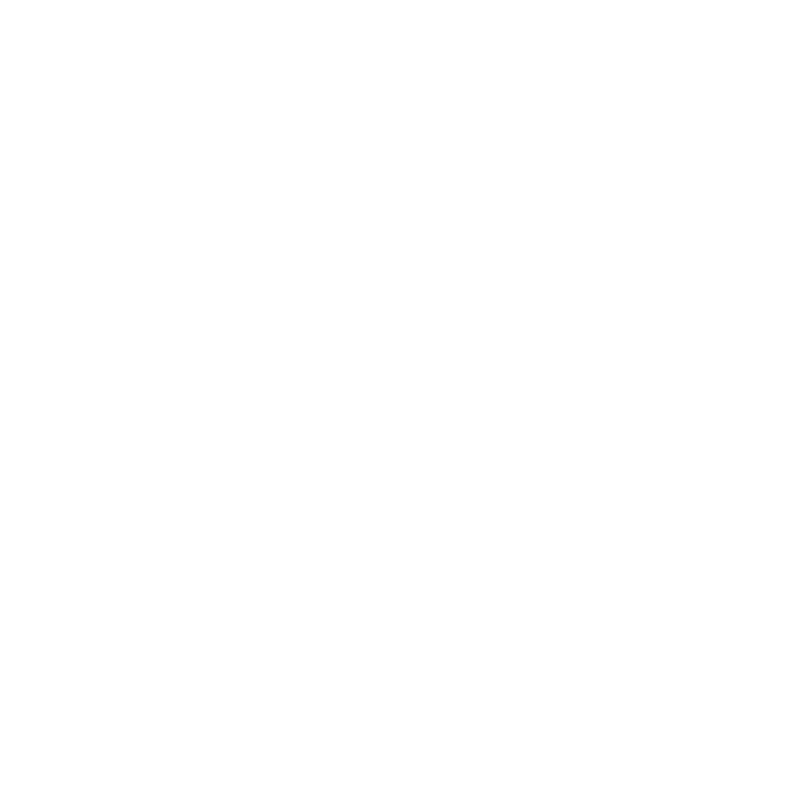

In [56]:
tensor_to_image(recon_map[0], 0, as_type='bool', detach=True)

In [22]:
# tensor_to_image(torch.softmax(recon_map[0], 0), astype='float', channel=3)
t = recon_map[0]
t

tensor([[[0.7311, 0.7311, 0.7311,  ..., 0.7311, 0.7311, 0.7311],
         [0.7311, 0.7311, 0.7311,  ..., 0.7311, 0.7311, 0.7311],
         [0.7311, 0.7311, 0.7311,  ..., 0.7311, 0.7311, 0.7311],
         ...,
         [0.7311, 0.7311, 0.7311,  ..., 0.7311, 0.7311, 0.7311],
         [0.7311, 0.7311, 0.7311,  ..., 0.7311, 0.7311, 0.7311],
         [0.7311, 0.7311, 0.7311,  ..., 0.7311, 0.7311, 0.7311]],

        [[0.7311, 0.7311, 0.7311,  ..., 0.7311, 0.7311, 0.7311],
         [0.7311, 0.7311, 0.7311,  ..., 0.7311, 0.7311, 0.7311],
         [0.7311, 0.7311, 0.7311,  ..., 0.7311, 0.7311, 0.7311],
         ...,
         [0.7311, 0.7311, 0.7311,  ..., 0.7311, 0.7311, 0.7311],
         [0.7311, 0.7311, 0.7311,  ..., 0.7311, 0.7311, 0.7311],
         [0.7311, 0.7311, 0.7311,  ..., 0.7311, 0.7311, 0.7311]],

        [[0.7311, 0.7311, 0.7311,  ..., 0.7311, 0.7311, 0.7311],
         [0.7311, 0.7311, 0.7311,  ..., 0.7311, 0.7311, 0.7311],
         [0.7311, 0.7311, 0.7311,  ..., 0.7311, 0.7311, 0.

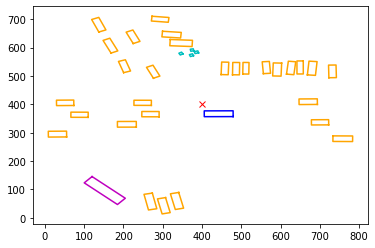

In [23]:
import matplotlib.pyplot as plt
from helpers.helper import draw_box
# The center of image is 400 * 400
fig, ax = plt.subplots()
color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']
# ax.imshow(road_image[0], cmap ='binary');
# The ego car position
ax.plot(400, 400, 'x', color="red")
for i, bb in enumerate(targets[0]['bounding_box']):
    # You can check the implementation of the draw box to understand how it works
    draw_box(ax, bb, color=color_list[targets[0]['category'][i]])